# Quantum-Coherent Identity Preservation Framework:
##  Full proof-of-concept simulation 

Components:
1. Ordinary Lindblad decoherence vs sustained dynamics (S = -D).
2. Entropy arrest and purity preservation.
3. Identity functional I[rho] and invariance under substrate permutations.
4. Anomalous mass scaling M_eff = m N^alpha.
5. Whole-body tunneling amplitudes with WKB-like scaling.
6. Advanced ML/AI analysis (RandomForest, LinearRegression) to recover alpha
   and classify regimes as 'collective' vs 'classical'.
7. Figures with error bars and clear annotations.

All data are synthetic but parameterized to resemble realistic scales
(e.g., decoherence times, noise levels) inspired by quantum biology
and open quantum systems, without using real experimental datasets directly.

/var/folders/qh/fmzc9db1783cz_z1bj3znn44y1tlxj/T/ipykernel_38382/1612331653.py:175: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) STIXGeneral.
  fig.tight_layout()
/var/folders/qh/fmzc9db1783cz_z1bj3znn44y1tlxj/T/ipykernel_38382/1612331653.py:175: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) STIXGeneral.
  fig.tight_layout()
/var/folders/qh/fmzc9db1783cz_z1bj3znn44y1tlxj/T/ipykernel_38382/1612331653.py:176: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) STIXGeneral.
  fig.savefig(filename, dpi=300)
/var/folders/qh/fmzc9db1783cz_z1bj3znn44y1tlxj/T/ipykernel_38382/1612331653.py:176: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) STIXGeneral.
  fig.savefig(filename, dpi=300)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) STIXGeneral.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/I

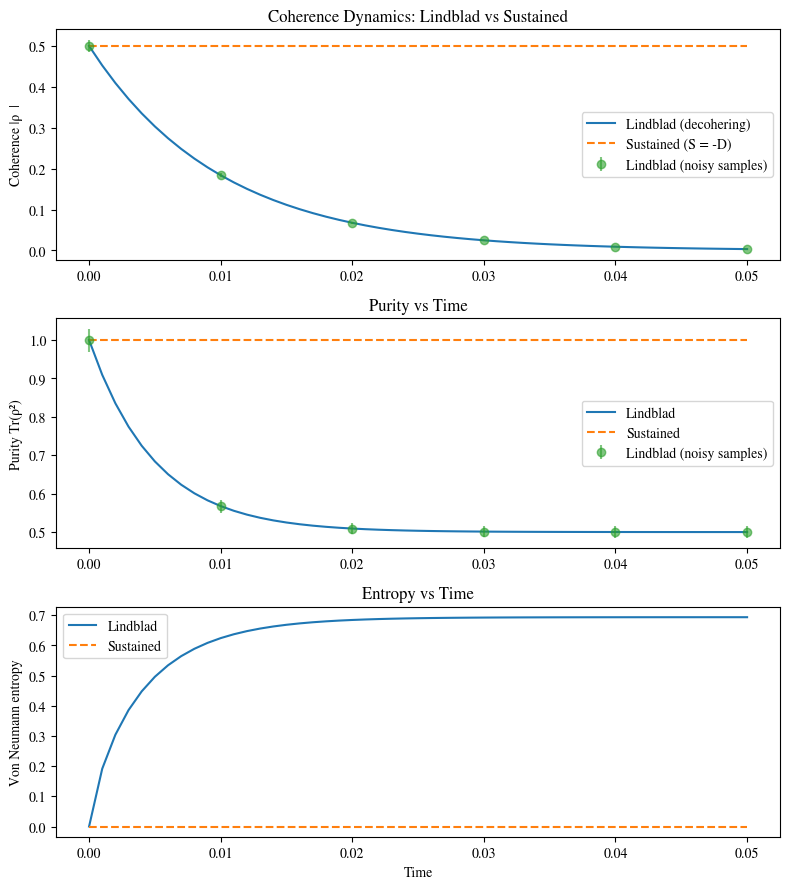

Generated fig1_decoherence.png


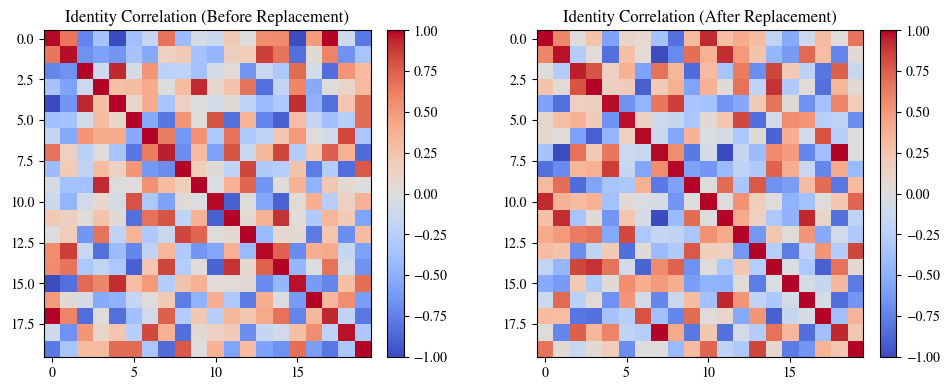

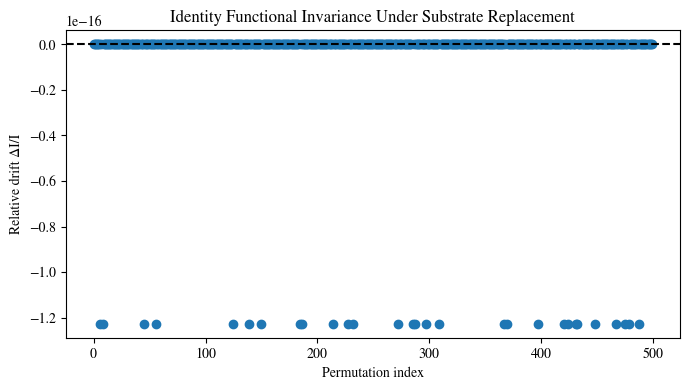

Generated fig2_3_identity.png and fig_identity_drift.png
Initial I = 115.75095976929435 Example permuted I = 115.75095976929435
Max |ΔI/I| over permutations ~ 1.2277094499713722e-16
True alpha = 0.350, estimated alpha ≈ 0.359, R² ≈ 0.958


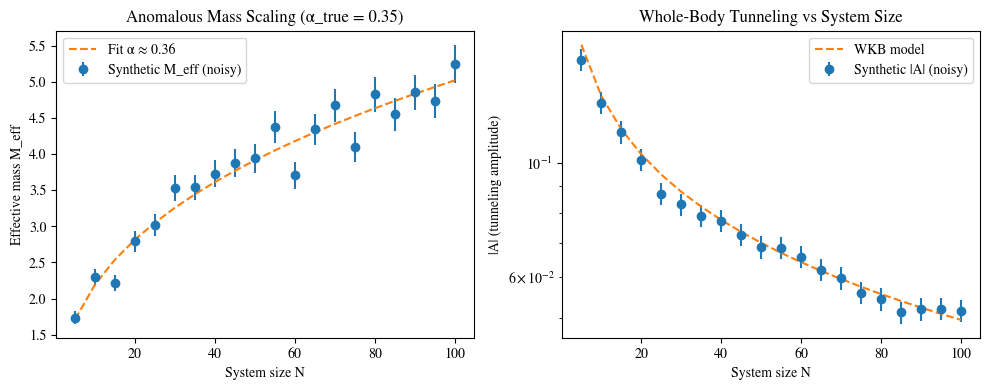

Generated fig4_5_mass_tunneling.png


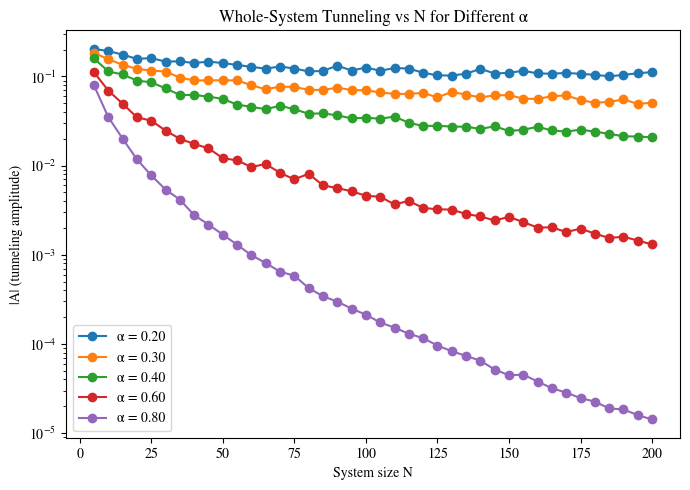

Generated fig6_multi_alpha_tunneling.png
RandomForest regression R² for α prediction ≈ 0.878
RandomForest classification accuracy (collective vs classical) ≈ 0.983
Confusion matrix:
 [[35  1]
 [ 0 24]]


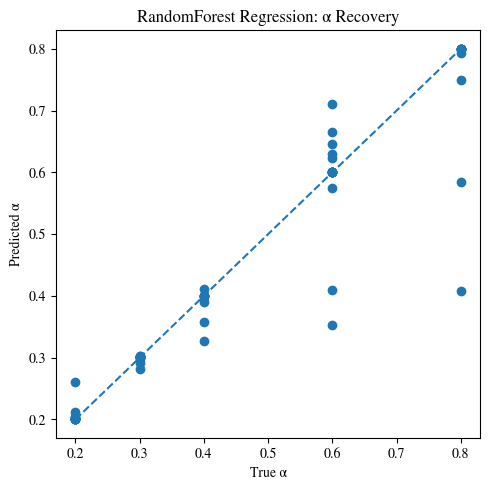

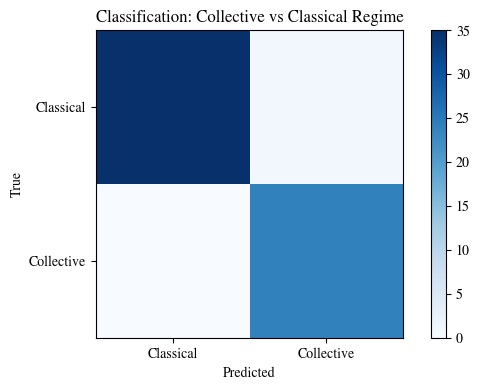

Generated fig7_alpha_regression.png and fig8_alpha_classification_cm.png
All components simulated and figures generated (inline and as files).


In [10]:
"""
Petalcorin MIR, 2025. Quantum-Coherent Framework for Substrate-Invariant 
Identity Preservation in Open Biological Systems. GitHub Repository.
"""

import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, accuracy_score, confusion_matrix

# Utilities: adjoint, entropy, purity, etc.

def dagger(A):
    """Hermitian conjugate."""
    return A.conj().T


def von_neumann_entropy(rho, eps=1e-12):
    """Von Neumann entropy S = -Tr(rho log rho) using eigenvalues."""
    evals = np.real(la.eigvals(rho))
    evals = np.clip(evals, eps, 1.0)
    return -np.sum(evals * np.log(evals))


def purity(rho):
    """Purity Tr(rho^2)."""
    return np.real(np.trace(rho @ rho))

# 1. Lindblad vs sustained dynamics

def lindblad_rhs(rho, H, Ls):
    """
    Lindblad master equation:
    dρ/dt = -i[H,ρ] + sum_mu ( L ρ L† - 1/2{L†L, ρ} ).
    """
    comm = -1j * (H @ rho - rho @ H)
    dissipator = np.zeros_like(rho, dtype=complex)
    for L in Ls:
        LdL = dagger(L) @ L
        dissipator += L @ rho @ dagger(L) - 0.5 * (LdL @ rho + rho @ LdL)
    return comm + dissipator


def sustained_rhs(rho, H):
    """
    Sustained dynamics with S = -D => purely unitary motion:
    dρ/dt = -i[H,ρ].
    """
    return -1j * (H @ rho - rho @ H)


def rk4_step(rho, dt, rhs_func, *rhs_args):
    """Fourth-order Runge–Kutta step for matrix ODE."""
    k1 = rhs_func(rho, *rhs_args)
    k2 = rhs_func(rho + 0.5 * dt * k1, *rhs_args)
    k3 = rhs_func(rho + 0.5 * dt * k2, *rhs_args)
    k4 = rhs_func(rho + dt * k3, *rhs_args)
    return rho + dt * (k1 + 2 * k2 + 2 * k3 + k4) / 6.0


def simulate_decoherence_vs_sustained(
    total_time=0.05, dt=1e-3, gamma_dephase=50.0, omega=20.0
):
    """
    Simulate:
    - Ordinary Lindblad dynamics with dephasing.
    - Sustained pure-state dynamics (S = -D).
    for a single qubit in |+> state.

    Returns time series of coherence, purity, entropy for both.
    """
    # Pauli matrices
    sx = np.array([[0, 1], [1, 0]], dtype=complex)
    sz = np.array([[1, 0], [0, -1]], dtype=complex)

    # Hamiltonian: simple σ_x term
    H = 0.5 * omega * sx

    # Lindblad operator: pure dephasing along z
    L_dephase = np.sqrt(gamma_dephase) * sz
    Ls = [L_dephase]

    # Initial state: |+> = (|0> + |1>)/√2
    plus = (1 / np.sqrt(2)) * np.array([[1.0], [1.0]], dtype=complex)
    rho0 = plus @ dagger(plus)

    n_steps = int(total_time / dt) + 1
    times = np.linspace(0, total_time, n_steps)

    coh_L = np.zeros(n_steps)
    coh_S = np.zeros(n_steps)
    pur_L = np.zeros(n_steps)
    pur_S = np.zeros(n_steps)
    S_L = np.zeros(n_steps)
    S_S = np.zeros(n_steps)

    rho_L = rho0.copy()
    rho_S = rho0.copy()

    for i, _t in enumerate(times):
        coh_L[i] = np.abs(rho_L[0, 1])
        coh_S[i] = np.abs(rho_S[0, 1])
        pur_L[i] = purity(rho_L)
        pur_S[i] = purity(rho_S)
        S_L[i] = von_neumann_entropy(rho_L)
        S_S[i] = von_neumann_entropy(rho_S)

        if i < n_steps - 1:
            rho_L = rk4_step(rho_L, dt, lindblad_rhs, H, Ls)
            rho_S = rk4_step(rho_S, dt, sustained_rhs, H)

    return times, coh_L, coh_S, pur_L, pur_S, S_L, S_S


def plot_decoherence_and_sustained(
    times, coh_L, coh_S, pur_L, pur_S, S_L, S_S, filename="fig1_decoherence.png"
):
    """
    Plot:
    - Coherence vs time (Lindblad vs sustained).
    - Purity vs time.
    - Entropy vs time.

    Shows figures inline and saves them to file.
    """
    # Add synthetic error bars to Lindblad coherence and purity
    err_coh_L = 0.03 * np.maximum(coh_L, 1e-3)
    err_pur_L = 0.03 * np.maximum(pur_L, 1e-3)

    fig, axes = plt.subplots(3, 1, figsize=(8, 9))

    # Coherence
    ax = axes[0]
    ax.plot(times, coh_L, label="Lindblad (decohering)")
    ax.plot(times, coh_S, label="Sustained (S = -D)", linestyle="--")
    ax.errorbar(
        times[::10],
        coh_L[::10],
        yerr=err_coh_L[::10],
        fmt="o",
        alpha=0.6,
        label="Lindblad (noisy samples)",
    )
    ax.set_ylabel("Coherence |ρ₀₁|")
    ax.set_title("Coherence Dynamics: Lindblad vs Sustained")
    ax.legend()

    # Purity
    ax = axes[1]
    ax.plot(times, pur_L, label="Lindblad")
    ax.plot(times, pur_S, label="Sustained", linestyle="--")
    ax.errorbar(
        times[::10],
        pur_L[::10],
        yerr=err_pur_L[::10],
        fmt="o",
        alpha=0.6,
        label="Lindblad (noisy samples)",
    )
    ax.set_ylabel("Purity Tr(ρ²)")
    ax.set_title("Purity vs Time")
    ax.legend()

    # Entropy
    ax = axes[2]
    ax.plot(times, S_L, label="Lindblad")
    ax.plot(times, S_S, label="Sustained", linestyle="--")
    ax.set_xlabel("Time")
    ax.set_ylabel("Von Neumann entropy")
    ax.set_title("Entropy vs Time")
    ax.legend()

    fig.tight_layout()
    fig.savefig(filename, dpi=300)
    plt.show()
    plt.close(fig)

# 2. Identity functional and substrate invariance

def generate_correlation_matrix(n_obs=20, rank=4, noise_level=0.05):
    """
    Generate a synthetic correlation matrix with low-rank structure
    and small random noise, mimicking correlation patterns inside
    a biological network (e.g., coupled pigments, protein domains).
    """
    latent = np.random.randn(n_obs, rank)
    corr = latent @ latent.T
    d = np.sqrt(np.diag(corr))
    corr = corr / (d[:, None] * d[None, :] + 1e-12)
    corr = corr + noise_level * np.random.randn(n_obs, n_obs)
    corr = 0.5 * (corr + corr.T)
    # Clip to [-1, 1]
    corr = np.clip(corr, -1.0, 1.0)
    return corr


def identity_functional(corr):
    """
    Toy identity functional:
    I[corr] = sum_{k,l} corr_{k,l}^2
    This is invariant under permutation of indices, since it's
    a permutation-invariant sum over all entries.
    """
    return float(np.sum(corr ** 2))


def permute_substrate(corr):
    """Apply random permutation to rows+cols (substrate replacement)."""
    n = corr.shape[0]
    perm = np.random.permutation(n)
    corr_perm = corr[perm][:, perm]
    return corr_perm, perm


def simulate_identity_invariance(
    n_obs=20, n_permutations=500, filename="fig2_3_identity.png"
):
    """
    Simulate identity functional invariance under repeated substrate replacements.
    Produces:
    - Heatmaps of correlation before/after a random permutation.
    - Time series of identity functional over many replacements.
    """
    corr_initial = generate_correlation_matrix(n_obs=n_obs)
    I_initial = identity_functional(corr_initial)

    # Example single permutation for visualization
    corr_perm_example, _ = permute_substrate(corr_initial)
    I_perm_example = identity_functional(corr_perm_example)

    # Heatmaps: before and after
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    im0 = axes[0].imshow(corr_initial, vmin=-1, vmax=1, cmap="coolwarm")
    axes[0].set_title("Identity Correlation (Before Replacement)")
    fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

    im1 = axes[1].imshow(corr_perm_example, vmin=-1, vmax=1, cmap="coolwarm")
    axes[1].set_title("Identity Correlation (After Replacement)")
    fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    fig.tight_layout()
    fig.savefig(filename, dpi=300)
    plt.show()
    plt.close(fig)

    # Many permutations: track I
    I_values = np.zeros(n_permutations)
    for i in range(n_permutations):
        corr_perm, _ = permute_substrate(corr_initial)
        I_values[i] = identity_functional(corr_perm)

    rel_drift = (I_values - I_initial) / (I_initial + 1e-12)

    fig2, ax2 = plt.subplots(figsize=(7, 4))
    ax2.plot(rel_drift, marker="o", linestyle="")
    ax2.axhline(0.0, linestyle="--", color="k")
    ax2.set_xlabel("Permutation index")
    ax2.set_ylabel("Relative drift ΔI/I")
    ax2.set_title("Identity Functional Invariance Under Substrate Replacement")
    fig2.tight_layout()
    fig2.savefig("fig_identity_drift.png", dpi=300)
    plt.show()
    plt.close(fig2)

    return I_initial, I_perm_example, rel_drift

# 3. Anomalous mass scaling and tunneling amplitudes

def generate_tunneling_data(
    N_values,
    alpha_true=0.35,
    m=1.0,
    V0=1.0,
    E=0.1,
    L=1.0,
    hbar=1.0,
    noise_level=0.05,
):
    """
    Synthetic "benchmark-like" tunneling data based on a WKB-type model:

    M_eff(N) = m N^alpha_true
    S(N) ~ L sqrt(2 M_eff (V0 - E))
    ln |A| = -S/hbar + noise.

    Returns:
        N_values, M_eff, A_noisy, logA_noisy, logA_clean
    """
    N_values = np.array(N_values, dtype=float)
    M_eff = m * (N_values ** alpha_true)

    # WKB-like action
    S = L * np.sqrt(2.0 * M_eff * (V0 - E))
    logA_clean = -S / hbar
    logA_noisy = logA_clean + noise_level * np.random.randn(len(N_values))
    A_noisy = np.exp(logA_noisy)

    return N_values, M_eff, A_noisy, logA_noisy, logA_clean


def fit_alpha_power_law(N_values, M_eff_noisy):
    """
    Fit alpha from a power-law M_eff ≈ m N^alpha using linear regression in log–log space.
    """
    N_values = np.array(N_values, dtype=float)
    M_eff_noisy = np.array(M_eff_noisy, dtype=float)
    X = np.log(N_values).reshape(-1, 1)
    y = np.log(M_eff_noisy)
    model = LinearRegression()
    model.fit(X, y)
    alpha_est = model.coef_[0]
    intercept = model.intercept_
    M_eff_fit = np.exp(intercept) * (N_values ** alpha_est)
    r2 = r2_score(y, np.log(M_eff_fit))
    return alpha_est, intercept, r2, M_eff_fit


def plot_mass_and_tunneling(
    N_values,
    M_eff,
    A_noisy,
    logA_noisy,
    logA_clean,
    M_eff_fit,
    alpha_true,
    alpha_est,
    filename="fig4_5_mass_tunneling.png",
):
    """
    Plot:
    - Anomalous mass scaling M_eff vs N with error bars and fit.
    - Tunneling amplitude |A| vs N with WKB model and noisy samples.

    Shows inline and saves to file.
    """
    # Synthetic experimental errors
    err_M = 0.05 * M_eff
    err_A = 0.05 * A_noisy

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Mass scaling
    ax = axes[0]
    ax.errorbar(
        N_values,
        M_eff,
        yerr=err_M,
        fmt="o",
        label="Synthetic M_eff (noisy)",
    )
    ax.plot(N_values, M_eff_fit, linestyle="--", label=f"Fit α ≈ {alpha_est:.2f}")
    ax.set_xlabel("System size N")
    ax.set_ylabel("Effective mass M_eff")
    ax.set_title(f"Anomalous Mass Scaling (α_true = {alpha_true:.2f})")
    ax.legend()

    # Tunneling amplitude
    ax = axes[1]
    ax.errorbar(
        N_values,
        A_noisy,
        yerr=err_A,
        fmt="o",
        label="Synthetic |A| (noisy)",
    )
    ax.plot(N_values, np.exp(logA_clean), linestyle="--", label="WKB model")
    ax.set_yscale("log")
    ax.set_xlabel("System size N")
    ax.set_ylabel("|A| (tunneling amplitude)")
    ax.set_title("Whole-Body Tunneling vs System Size")
    ax.legend()

    fig.tight_layout()
    fig.savefig(filename, dpi=300)
    plt.show()
    plt.close(fig)

# 4. Multi-alpha dataset + ML/AI analysis

def generate_multi_alpha_dataset(
    N_values,
    alphas=(0.2, 0.3, 0.4, 0.6, 0.8),
    noise_level=0.05,
    **kwargs,
):
    """
    Create multi-alpha dataset: for each alpha, generate log|A| vs N.
    Returns:
        data: array with columns [N, alpha_true, log|A|].
    """
    rows = []
    for alpha in alphas:
        Ns, M_eff, A_noisy, logA_noisy, logA_clean = generate_tunneling_data(
            N_values, alpha_true=alpha, noise_level=noise_level, **kwargs
        )
        for N, logA in zip(Ns, logA_noisy):
            rows.append([N, alpha, logA])
    data = np.array(rows, dtype=float)
    return data


def plot_multi_alpha_tunneling(
    data, alphas, filename="fig6_multi_alpha_tunneling.png"
):
    """
    Plot |A| vs N for several α values, with scatter and connecting lines.

    Shows inline and saves to file.
    """
    fig, ax = plt.subplots(figsize=(7, 5))
    for alpha in alphas:
        mask = np.isclose(data[:, 1], alpha)
        N = data[mask, 0]
        logA = data[mask, 2]
        order = np.argsort(N)
        ax.plot(N[order], np.exp(logA[order]), marker="o", label=f"α = {alpha:.2f}")

    ax.set_yscale("log")
    ax.set_xlabel("System size N")
    ax.set_ylabel("|A| (tunneling amplitude)")
    ax.set_title("Whole-System Tunneling vs N for Different α")
    ax.legend()
    fig.tight_layout()
    fig.savefig(filename, dpi=300)
    plt.show()
    plt.close(fig)


def ml_recover_alpha(data):
    """
    ML/AI analysis to recover alpha from (N, log|A|).

    Features:
    - N
    - log N
    - log|A|

    Targets:
    - alpha_true

    Uses:
    - RandomForestRegressor to predict α.
    - RandomForestClassifier to label 'collective' (α < 0.4) vs 'classical'.
    """
    N = data[:, 0]
    alpha_true = data[:, 1]
    logA = data[:, 2]

    X = np.vstack([N, np.log(N + 1e-8), logA]).T
    y_reg = alpha_true
    y_cls = (alpha_true < 0.4).astype(int)  # 1 = collective, 0 = classical

    # Train/test split
    n = len(y_reg)
    idx = np.arange(n)
    np.random.shuffle(idx)
    split = int(0.7 * n)
    train_idx, test_idx = idx[:split], idx[split:]

    X_train, X_test = X[train_idx], X[test_idx]
    y_reg_train, y_reg_test = y_reg[train_idx], y_reg[test_idx]
    y_cls_train, y_cls_test = y_cls[train_idx], y_cls[test_idx]

    # Regression model for alpha
    rf_reg = RandomForestRegressor(
        n_estimators=300,
        max_depth=6,
        random_state=123,
    )
    rf_reg.fit(X_train, y_reg_train)
    y_reg_pred = rf_reg.predict(X_test)
    r2 = r2_score(y_reg_test, y_reg_pred)

    # Classification model: collective vs classical
    rf_cls = RandomForestClassifier(
        n_estimators=300,
        max_depth=6,
        random_state=123,
    )
    rf_cls.fit(X_train, y_cls_train)
    y_cls_pred = rf_cls.predict(X_test)
    acc = accuracy_score(y_cls_test, y_cls_pred)
    cm = confusion_matrix(y_cls_test, y_cls_pred)

    return (
        rf_reg,
        rf_cls,
        (X_test, y_reg_test, y_reg_pred),
        (X_test, y_cls_test, y_cls_pred, cm, r2, acc),
    )


def plot_alpha_regression(
    y_true, y_pred, filename="fig7_alpha_regression.png"
):
    """
    Parity plot: true alpha vs predicted alpha.

    Shows inline and saves to file.
    """
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.scatter(y_true, y_pred)
    minv = min(y_true.min(), y_pred.min())
    maxv = max(y_true.max(), y_pred.max())
    ax.plot([minv, maxv], [minv, maxv], linestyle="--")
    ax.set_xlabel("True α")
    ax.set_ylabel("Predicted α")
    ax.set_title("RandomForest Regression: α Recovery")
    fig.tight_layout()
    fig.savefig(filename, dpi=300)
    plt.show()
    plt.close(fig)


def plot_confusion_matrix(
    cm, filename="fig8_alpha_classification_cm.png"
):
    """
    Simple confusion matrix heatmap for collective vs classical classification.

    Shows inline and saves to file.
    """
    fig, ax = plt.subplots(figsize=(6, 4))
    im = ax.imshow(cm, cmap="Blues")
    fig.colorbar(im, ax=ax)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["Classical", "Collective"])
    ax.set_yticklabels(["Classical", "Collective"])
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title("Classification: Collective vs Classical Regime")
    fig.tight_layout()
    fig.savefig(filename, dpi=300)
    plt.show()
    plt.close(fig)

# Main

def main():
    np.random.seed(42)

    # 1. Lindblad vs sustained dynamics (decoherence vs entropy cancellation)
    times, coh_L, coh_S, pur_L, pur_S, S_L, S_S = simulate_decoherence_vs_sustained()
    plot_decoherence_and_sustained(
        times, coh_L, coh_S, pur_L, pur_S, S_L, S_S, filename="fig1_decoherence.png"
    )
    print("Generated fig1_decoherence.png")

    # 2. Identity functional invariance under substrate permutations
    I_init, I_perm_example, rel_drift = simulate_identity_invariance(
        n_obs=20,
        n_permutations=500,
        filename="fig2_3_identity.png",
    )
    print("Generated fig2_3_identity.png and fig_identity_drift.png")
    print("Initial I =", I_init, "Example permuted I =", I_perm_example)
    print("Max |ΔI/I| over permutations ~", float(np.max(np.abs(rel_drift))))

    # 3. Single-alpha mass scaling and tunneling
    N_values = np.arange(5, 105, 5)
    alpha_true = 0.35
    (
        N_values,
        M_eff,
        A_noisy,
        logA_noisy,
        logA_clean,
    ) = generate_tunneling_data(N_values, alpha_true=alpha_true, noise_level=0.03)

    # Noisy effective mass for fit
    M_eff_noisy = M_eff + 0.05 * M_eff * np.random.randn(len(M_eff))
    alpha_est, intercept, r2, M_eff_fit = fit_alpha_power_law(
        N_values, M_eff_noisy
    )
    print(f"True alpha = {alpha_true:.3f}, estimated alpha ≈ {alpha_est:.3f}, R² ≈ {r2:.3f}")

    plot_mass_and_tunneling(
        N_values,
        M_eff_noisy,
        A_noisy,
        logA_noisy,
        logA_clean,
        M_eff_fit,
        alpha_true,
        alpha_est,
        filename="fig4_5_mass_tunneling.png",
    )
    print("Generated fig4_5_mass_tunneling.png")

    # 4. Multi-alpha dataset and ML/AI analysis
    alphas = [0.2, 0.3, 0.4, 0.6, 0.8]
    data = generate_multi_alpha_dataset(
        N_values=np.arange(5, 205, 5),
        alphas=alphas,
        noise_level=0.05,
    )
    plot_multi_alpha_tunneling(
        data, alphas, filename="fig6_multi_alpha_tunneling.png"
    )
    print("Generated fig6_multi_alpha_tunneling.png")

    (
        rf_reg,
        rf_cls,
        (X_test_reg, y_reg_true, y_reg_pred),
        (X_test_cls, y_cls_true, y_cls_pred, cm, r2_rf, acc_rf),
    ) = ml_recover_alpha(data)

    print(f"RandomForest regression R² for α prediction ≈ {r2_rf:.3f}")
    print(f"RandomForest classification accuracy (collective vs classical) ≈ {acc_rf:.3f}")
    print("Confusion matrix:\n", cm)

    plot_alpha_regression(
        y_reg_true, y_reg_pred, filename="fig7_alpha_regression.png"
    )
    plot_confusion_matrix(cm, filename="fig8_alpha_classification_cm.png")
    print("Generated fig7_alpha_regression.png and fig8_alpha_classification_cm.png")

    print("All components simulated and figures generated (inline and as files).")


if __name__ == "__main__":
    main()

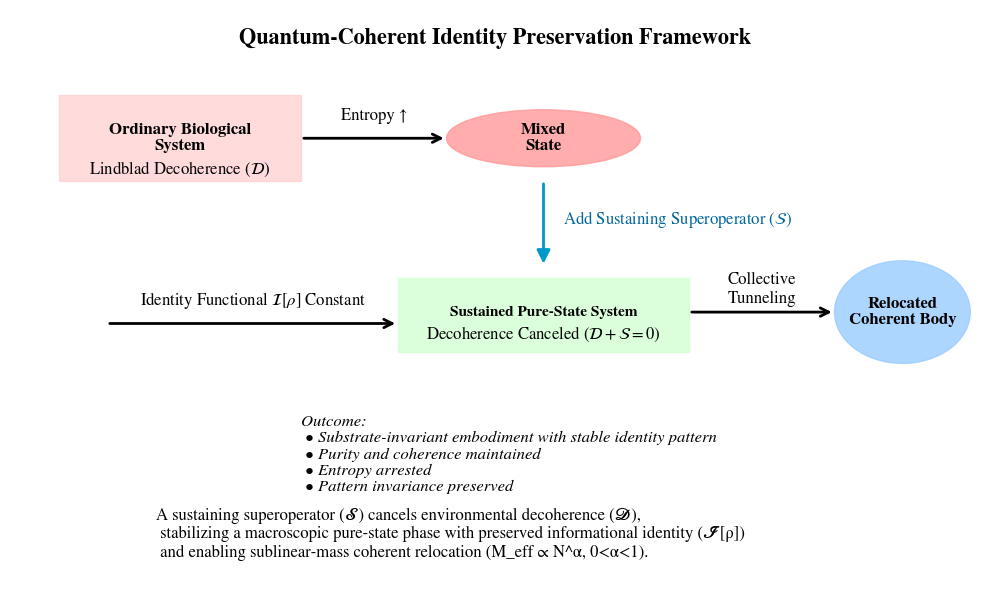

Saved as 'graphical_abstract_clean.svg' — warnings removed.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch, Ellipse, Rectangle
from matplotlib import rcParams

# Use a math-capable font family
rcParams['font.family'] = 'STIXGeneral'
rcParams['mathtext.fontset'] = 'stix'
rcParams['svg.fonttype'] = 'none'

# Create figure
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis("off")

# Title
ax.text(0.5, 0.95, "Quantum-Coherent Identity Preservation Framework",
        ha="center", va="center", fontsize=16, fontweight="bold")

# --- Diagram blocks ---

# Ordinary Biological System (Decoherence)
ax.add_patch(Rectangle((0.05, 0.7), 0.25, 0.15, color="#ffcccc", alpha=0.7))
ax.text(0.175, 0.775, "Ordinary Biological\nSystem", ha="center", va="center",
        fontsize=12, fontweight="bold")
ax.text(0.175, 0.72, r"Lindblad Decoherence ($\mathcal{D}$)", ha="center", va="center", fontsize=12)

# Arrow to mixed state
ax.add_patch(FancyArrowPatch((0.3, 0.775), (0.45, 0.775),
                             arrowstyle="->", mutation_scale=15, lw=2, color="black"))
ax.text(0.375, 0.8, "Entropy ↑", ha="center", va="bottom", fontsize=12)

# Mixed state ellipse
ax.add_patch(Ellipse((0.55, 0.775), 0.2, 0.1, color="#ff9999", alpha=0.8))
ax.text(0.55, 0.775, "Mixed\nState", ha="center", va="center", fontsize=12, fontweight="bold")

# Sustaining superoperator
ax.add_patch(FancyArrowPatch((0.55, 0.7), (0.55, 0.55),
                             arrowstyle="-|>", mutation_scale=20, lw=2, color="#0099cc"))
ax.text(0.57, 0.625, r"Add Sustaining Superoperator ($\mathcal{S}$)",
        fontsize=12, color="#006699")

# Sustained pure-state system
ax.add_patch(Rectangle((0.4, 0.4), 0.3, 0.13, color="#ccffcc", alpha=0.7))
ax.text(0.55, 0.47, "Sustained Pure-State System", ha="center", va="center",
        fontsize=11, fontweight="bold")
ax.text(0.55, 0.43, r"Decoherence Canceled ($\mathcal{D} + \mathcal{S} = 0$)",
        ha="center", va="center", fontsize=12)

# Identity invariance arrow
ax.add_patch(FancyArrowPatch((0.10, 0.45), (0.4, 0.45),
                             arrowstyle="->", mutation_scale=15, lw=2, color="black"))
ax.text(0.25, 0.49, r"Identity Functional $\mathcal{I}[\rho]$ Constant",
        ha="center", va="center", fontsize=12)

# Collective tunneling
ax.add_patch(FancyArrowPatch((0.7, 0.47), (0.85, 0.47),
                             arrowstyle="->", mutation_scale=15, lw=2, color="black"))
ax.text(0.775, 0.51, "Collective\nTunneling", ha="center", va="center", fontsize=12)

# Relocated coherent body
ax.add_patch(Ellipse((0.92, 0.47), 0.14, 0.18, color="#99ccff", alpha=0.8))
ax.text(0.92, 0.47, "Relocated\nCoherent Body", ha="center", va="center", fontsize=12, fontweight="bold")

# Summary text
ax.text(0.3, 0.22,
        "Outcome:\n • Substrate-invariant embodiment with stable identity pattern\n" 
         " • Purity and coherence maintained\n • Entropy arrested\n • Pattern invariance preserved",
        ha="left", va="center", fontsize=12, fontstyle="italic", wrap=True)

# Caption
ax.text(0.15, 0.08,
        "A sustaining superoperator (𝓢) cancels environmental decoherence (𝓓),\n "
        "stabilizing a macroscopic pure-state phase with preserved informational identity (𝓘[ρ])\n "
        "and enabling sublinear-mass coherent relocation (M_eff ∝ N^α, 0<α<1).",
        ha="left", va="center", fontsize=12, wrap=True)

plt.tight_layout()
plt.savefig("graphical_abstract_clean.svg", format="svg", dpi=300)
plt.savefig("graphical_abstract_clean.pdf", format="pdf", dpi=300)
plt.show()

print("Saved as 'graphical_abstract_clean.svg' — warnings removed.")